**Experiment 5 - Adding run/pass play counts**

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
import xgboost as xgb
import warnings

In [7]:
exp5_df = pd.read_csv('../../Data/play-by-play/pbp_exp5.csv')

categorical_cols = ['OffenseTeam', 'DefenseTeam', 'play_type', 'side_of_field','stadium','play_type_nfl','roof','surface_type','home_team', 'away_team','season_type','offense_formation']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    exp5_df[col] = le.fit_transform(exp5_df[col].astype(str))
    label_encoders[col] = le  # Save encoders if needed later

Confusion Matrix for fold 1:
[[1065  554]
 [ 885  734]]


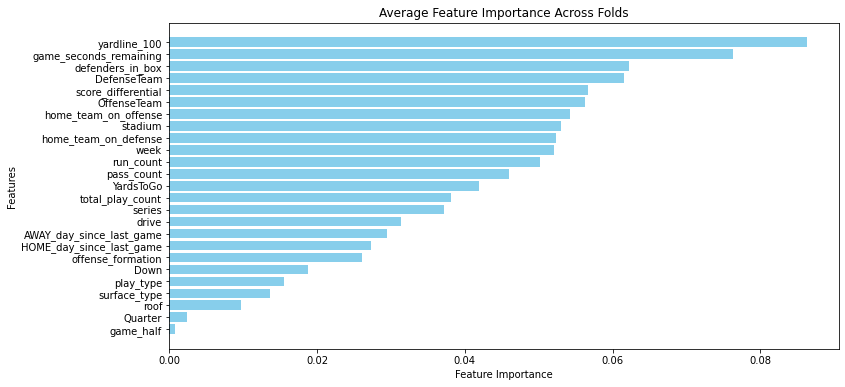

Accuracy scores for each fold: [0.43607164916615193, 0.5555898702903026, 0.5938851142680667, 0.47745521927115503, 0.483940704138357, 0.5398394070413836, 0.5163681284743669, 0.5361334156886968, 0.5231624459542927, 0.4845583693638048, 0.5067943174799259, 0.5216182828906732, 0.5667078443483632, 0.5308832612723904, 0.5231624459542927, 0.5546633724521309, 0.5873996294008648, 0.5163681284743669, 0.5333539221741815, 0.5552810376775787, 0.5534280420012353, 0.4654107473749228, 0.5361334156886968, 0.5716491661519456, 0.4722050648548487, 0.4737492279184682, 0.5861642989499691, 0.5410747374922792, 0.5382952439777641, 0.6145768993205682, 0.5277949351451513, 0.5389129092032119, 0.5067943174799259, 0.516059295861643, 0.49536751080914143, 0.5907967881408277, 0.5438542310067943, 0.5392217418159357, 0.5605311920938851, 0.561148857319333, 0.5531192093885114, 0.573810994441013, 0.5697961704756023, 0.5089561457689932, 0.5135886349598517, 0.6050030883261273, 0.5753551575046325, 0.5410747374922792, 0.5188387

In [ ]:
X = exp5_df[['week', 'OffenseTeam', 'DefenseTeam', 'Down', 'YardsToGo', 'yardline_100', 'play_type',
               'Quarter', 'game_seconds_remaining', 'game_half', 'drive', 'series', 'score_differential',
               'stadium', 'roof', 'surface_type', 'HOME_day_since_last_game', 'AWAY_day_since_last_game',
               'total_play_count', 'home_team_on_offense', 'home_team_on_defense',
               'defenders_in_box', 'offense_formation',
               'pass_count', 'run_count']]


y = exp5_df['Player-Injured-On-Play']

# Define Stratified K-Fold
k = 53  # Number of splits
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

accuracy_scores = []
precision_scores = []
feature_importances = np.zeros(X.shape[1])

accuracy_scores = []
precision_scores = []
recall_scores = []
feature_importances = np.zeros(X.shape[1])

# Perform stratified K-Fold cross-validation
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Separate injured and non-injured plays
    X_train_pos = X_train[y_train == 1]
    X_train_neg = X_train[y_train == 0]
    y_train_pos = y_train[y_train == 1]
    y_train_neg = y_train[y_train == 0]

    X_test_pos = X_test[y_test == 1]
    X_test_neg = X_test[y_test == 0]
    y_test_pos = y_test[y_test == 1]
    y_test_neg = y_test[y_test == 0]

    # Resample to ensure balance
    X_train_pos_resampled, y_train_pos_resampled = resample(X_train_pos, y_train_pos, replace=True, n_samples=1619, random_state=42)
    X_train_neg_resampled, y_train_neg_resampled = resample(X_train_neg, y_train_neg, replace=False, n_samples=1619, random_state=42)

    X_test_pos_resampled, y_test_pos_resampled = resample(X_test_pos, y_test_pos, replace=True, n_samples=1619, random_state=42)
    X_test_neg_resampled, y_test_neg_resampled = resample(X_test_neg, y_test_neg, replace=False, n_samples=1619, random_state=42)

    # Combine resampled data
    X_train_resampled = pd.concat([X_train_pos_resampled, X_train_neg_resampled])
    y_train_resampled = pd.concat([y_train_pos_resampled, y_train_neg_resampled])

    X_test_resampled = pd.concat([X_test_pos_resampled, X_test_neg_resampled])
    y_test_resampled = pd.concat([y_test_pos_resampled, y_test_neg_resampled])

    # Train RandomForest model
    dt_model = DecisionTreeClassifier(random_state=42)
    dt_model.fit(X_train_resampled, y_train_resampled)
    
    # Predict & Evaluate
    y_pred = dt_model.predict(X_test_resampled)
    accuracy = accuracy_score(y_test_resampled, y_pred)
    precision = precision_score(y_test_resampled, y_pred)
    recall = recall_score(y_test_resampled, y_pred)

    # Append results to lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)

    # Store feature importances
    feature_importances += dt_model.feature_importances_

    # Get confusion matrix for a specific fold
    if fold == 1:  
        cm = confusion_matrix(y_test_resampled, y_pred)
        print(f'Confusion Matrix for fold {fold}:')
        print(cm)

# Compute average feature importance
feature_importances /= k

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = X.columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Plot feature importances
plt.figure(figsize=(12, 6), facecolor='white')
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Average Feature Importance Across Folds')
plt.gca().invert_yaxis()
plt.show()

# Print cross-validation results
print(f'Accuracy scores for each fold: {accuracy_scores}')
print(f'Mean Accuracy: {np.mean(accuracy_scores):.4f}')
print(f'Standard Deviation: {np.std(accuracy_scores):.4f}')

print(f'Precision scores for each fold: {precision_scores}')
print(f'Mean Precision: {np.mean(precision_scores):.4f}')
print(f'Standard Deviation: {np.std(precision_scores):.4f}')

print(f'Recall scores for each fold: {recall_scores}')
print(f'Mean Recall: {np.mean(recall_scores):.4f}')
print(f'Standard Deviation: {np.std(recall_scores):.4f}')

Adding run & pass play features makes DT model worse, will not use in future experiments

**Experiment 6 - Switching to Random Forests Model for improved performance**

Confusion Matrix for fold 1:
[[1204  415]
 [1062  557]]


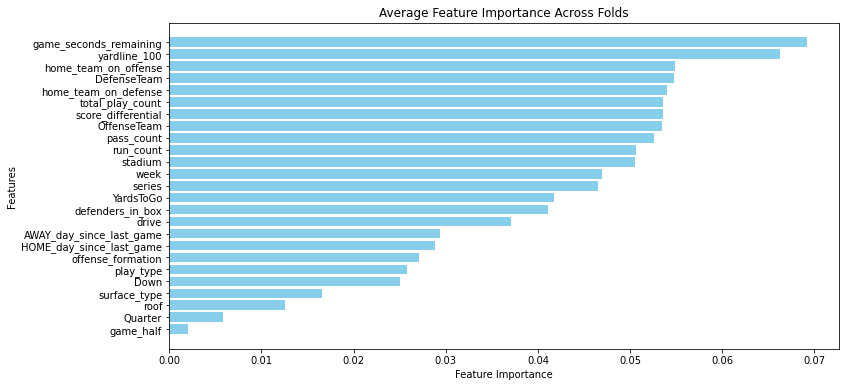

Accuracy scores for each fold: [0.5531192093885114, 0.5438542310067943, 0.5697961704756023, 0.46201358863495984, 0.6040765904879555, 0.5793699814700433, 0.5589870290302656, 0.5466337245213094, 0.5293390982087709, 0.5821494749845584, 0.551266213712168, 0.5330450895614577, 0.5775169857936998, 0.5778258184064237, 0.618591723285979, 0.5663990117356393, 0.5491043854231007, 0.5228536133415689, 0.6741815935762816, 0.5225447807288449, 0.5818406423718344, 0.6127239036442248, 0.5265596046942557, 0.5654725138974676, 0.5633106856084003, 0.5336627547869055, 0.5302655960469426, 0.5645460160592959, 0.6497838171710932, 0.5420012353304509, 0.608709079678814, 0.5589870290302656, 0.5475602223594812, 0.5571340333539222, 0.608709079678814, 0.5386040765904879, 0.6226065472513898, 0.5453983940704138, 0.618591723285979, 0.5151327980234712, 0.5491043854231007, 0.5497220506485485, 0.6327980234712786, 0.557442865966646, 0.5586781964175417, 0.5543545398394071, 0.6457689932056825, 0.5154416306361952, 0.56207535515

In [ ]:
X = exp5_df[['week', 'OffenseTeam', 'DefenseTeam', 'Down', 'YardsToGo', 'yardline_100', 'play_type',
               'Quarter', 'game_seconds_remaining', 'game_half', 'drive', 'series', 'score_differential',
               'stadium', 'roof', 'surface_type', 'HOME_day_since_last_game', 'AWAY_day_since_last_game',
               'total_play_count', 'home_team_on_offense', 'home_team_on_defense',
               'defenders_in_box', 'offense_formation',
               'pass_count', 'run_count']]


y = exp5_df['Player-Injured-On-Play']

# Define Stratified K-Fold
k = 53  # Number of splits
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

accuracy_scores = []
precision_scores = []
recall_scores = []
feature_importances = np.zeros(X.shape[1])


# Perform stratified K-Fold cross-validation
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Separate injured and non-injured plays
    X_train_pos = X_train[y_train == 1]
    X_train_neg = X_train[y_train == 0]
    y_train_pos = y_train[y_train == 1]
    y_train_neg = y_train[y_train == 0]

    X_test_pos = X_test[y_test == 1]
    X_test_neg = X_test[y_test == 0]
    y_test_pos = y_test[y_test == 1]
    y_test_neg = y_test[y_test == 0]

    # Resample to ensure balance
    X_train_pos_resampled, y_train_pos_resampled = resample(X_train_pos, y_train_pos, replace=True, n_samples=1619, random_state=42)
    X_train_neg_resampled, y_train_neg_resampled = resample(X_train_neg, y_train_neg, replace=False, n_samples=1619, random_state=42)

    X_test_pos_resampled, y_test_pos_resampled = resample(X_test_pos, y_test_pos, replace=True, n_samples=1619, random_state=42)
    X_test_neg_resampled, y_test_neg_resampled = resample(X_test_neg, y_test_neg, replace=False, n_samples=1619, random_state=42)

    # Combine resampled data
    X_train_resampled = pd.concat([X_train_pos_resampled, X_train_neg_resampled])
    y_train_resampled = pd.concat([y_train_pos_resampled, y_train_neg_resampled])

    X_test_resampled = pd.concat([X_test_pos_resampled, X_test_neg_resampled])
    y_test_resampled = pd.concat([y_test_pos_resampled, y_test_neg_resampled])

    # Train RandomForest model
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train_resampled, y_train_resampled)
    
    # Predict & Evaluate
    y_pred = rf_model.predict(X_test_resampled)
    accuracy = accuracy_score(y_test_resampled, y_pred)
    precision = precision_score(y_test_resampled, y_pred)
    recall = recall_score(y_test_resampled, y_pred)

    # Append results to lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)

    # Store feature importances
    feature_importances += rf_model.feature_importances_

    # Get confusion matrix for a specific fold
    if fold == 1:  
        cm = confusion_matrix(y_test_resampled, y_pred)
        print(f'Confusion Matrix for fold {fold}:')
        print(cm)

# Compute average feature importance
feature_importances /= k

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = X.columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Plot feature importances
plt.figure(figsize=(12, 6), facecolor='white')
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Average Feature Importance Across Folds')
plt.gca().invert_yaxis()
plt.show()

# Print cross-validation results
print(f'Accuracy scores for each fold: {accuracy_scores}')
print(f'Mean Accuracy: {np.mean(accuracy_scores):.4f}')
print(f'Standard Deviation: {np.std(accuracy_scores):.4f}')

print(f'Precision scores for each fold: {precision_scores}')
print(f'Mean Precision: {np.mean(precision_scores):.4f}')
print(f'Standard Deviation: {np.std(precision_scores):.4f}')

print(f'Recall scores for each fold: {recall_scores}')
print(f'Mean Recall: {np.mean(recall_scores):.4f}')
print(f'Standard Deviation: {np.std(recall_scores):.4f}')

**EXPERIMENT 7 - Trying Gradient Boosting Model**

Confusion Matrix for fold 1:
[[1109  510]
 [ 885  734]]


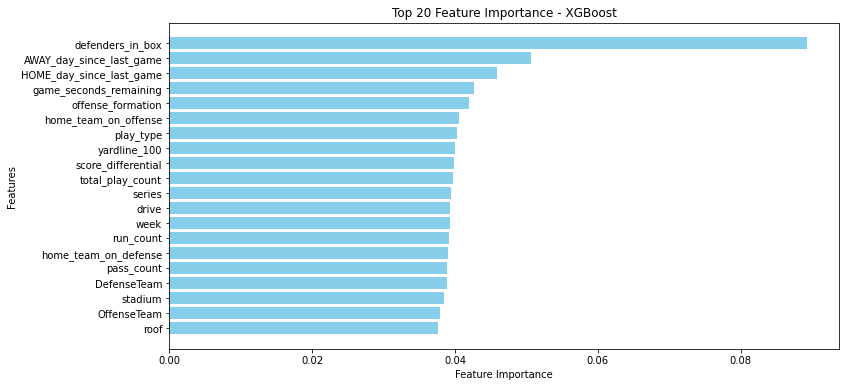

Accuracy scores for each fold: [0.5089561457689932, 0.5691785052501545, 0.5438542310067943, 0.5111179740580605, 0.5138974675725757, 0.5599135268684373, 0.4811612106238419, 0.5694873378628783, 0.3628783199505868, 0.5423100679431748, 0.535515750463249, 0.49876466954910437, 0.5453983940704138, 0.5583693638048178, 0.5889437924644843, 0.6300185299567634, 0.535515750463249, 0.5077208153180975, 0.6420630018529957, 0.5469425571340334, 0.5642371834465719, 0.583384805435454, 0.4814700432365658, 0.5793699814700433, 0.5633106856084003, 0.5247066090179123, 0.5450895614576899, 0.5101914762198888, 0.612415071031501, 0.5453983940704138, 0.5889437924644843, 0.5506485484867202, 0.557442865966646, 0.5287214329833231, 0.5744286596664607, 0.5558987029030266, 0.5963557751698579, 0.6062384187770229, 0.6065472513897467, 0.5818406423718344, 0.5281037677578753, 0.5716491661519456, 0.6590487955528104, 0.5735021618282891, 0.5898702903026559, 0.5376775787523163, 0.5243977764051884, 0.5302655960469426, 0.5142063001

In [ ]:
warnings.filterwarnings('ignore')

X = exp5_df[['week', 'OffenseTeam', 'DefenseTeam', 'Down', 'YardsToGo', 'yardline_100', 'play_type',
               'Quarter', 'game_seconds_remaining', 'game_half', 'drive', 'series', 'score_differential',
               'stadium', 'roof', 'surface_type', 'HOME_day_since_last_game', 'AWAY_day_since_last_game',
               'total_play_count', 'home_team_on_offense', 'home_team_on_defense',
               'defenders_in_box', 'offense_formation',
               'pass_count', 'run_count']]

y = exp5_df['Player-Injured-On-Play']

# Define Stratified K-Fold
k = 53  # Number of folds
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

accuracy_scores = []
precision_scores = []
recall_scores = []
feature_importances = np.zeros(X.shape[1])

# Perform stratified K-Fold cross-validation
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Separate injured and non-injured plays
    X_train_pos = X_train[y_train == 1]
    X_train_neg = X_train[y_train == 0]
    y_train_pos = y_train[y_train == 1]
    y_train_neg = y_train[y_train == 0]

    X_test_pos = X_test[y_test == 1]
    X_test_neg = X_test[y_test == 0]
    y_test_pos = y_test[y_test == 1]
    y_test_neg = y_test[y_test == 0]

    # Resample to ensure balance
    X_train_pos_resampled, y_train_pos_resampled = resample(X_train_pos, y_train_pos, replace=True, n_samples=1619, random_state=42)
    X_train_neg_resampled, y_train_neg_resampled = resample(X_train_neg, y_train_neg, replace=False, n_samples=1619, random_state=42)

    X_test_pos_resampled, y_test_pos_resampled = resample(X_test_pos, y_test_pos, replace=True, n_samples=1619, random_state=42)
    X_test_neg_resampled, y_test_neg_resampled = resample(X_test_neg, y_test_neg, replace=False, n_samples=1619, random_state=42)

    # Combine resampled data
    X_train_resampled = pd.concat([X_train_pos_resampled, X_train_neg_resampled])
    y_train_resampled = pd.concat([y_train_pos_resampled, y_train_neg_resampled])

    X_test_resampled = pd.concat([X_test_pos_resampled, X_test_neg_resampled])
    y_test_resampled = pd.concat([y_test_pos_resampled, y_test_neg_resampled])

    # Train XGBoost model
    xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb_model.fit(X_train_resampled, y_train_resampled)
    
    # Store feature importances
    feature_importances += xgb_model.feature_importances_

    # Predict & Evaluate
    y_pred = xgb_model.predict(X_test_resampled)
    accuracy = accuracy_score(y_test_resampled, y_pred)
    precision = precision_score(y_test_resampled, y_pred)
    recall = recall_score(y_test_resampled, y_pred)

    # Append results to lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)

    # Confusion matrix for the first fold
    if fold == 1:  
        cm = confusion_matrix(y_test_resampled, y_pred)
        print(f'Confusion Matrix for fold {fold}:')
        print(cm)

# Compute average feature importance
feature_importances /= k

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = X.columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Plot feature importances
plt.figure(figsize=(12, 6), facecolor='white')
plt.barh(sorted_features[:20], sorted_importances[:20], color='skyblue')  # Top 20 features
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 20 Feature Importance - XGBoost')
plt.gca().invert_yaxis()
plt.show()

print(f'Accuracy scores for each fold: {accuracy_scores}')
print(f'Mean Accuracy: {np.mean(accuracy_scores):.4f}')
print(f'Standard Deviation: {np.std(accuracy_scores):.4f}')

print(f'Precision scores for each fold: {precision_scores}')
print(f'Mean Precision: {np.mean(precision_scores):.4f}')
print(f'Standard Deviation: {np.std(precision_scores):.4f}')

print(f'Recall scores for each fold: {recall_scores}')
print(f'Mean Recall: {np.mean(recall_scores):.4f}')
print(f'Standard Deviation: {np.std(recall_scores):.4f}')